In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import os
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from scipy.stats import stats
sns.set(style="whitegrid", color_codes=True)
plt.rcParams['figure.figsize'] = (12, 12)

In [2]:
ndvi_img_dir = "/home/dat/Workspace/Thesis/lettuce_detector/data/raw/2017-10-27_Ortho/NDVI/lettuce"
csv_file = "/home/dat/Workspace/Thesis/data/Spreadsheet/Lettuce/2017-10-27.csv"

### Distribution of NDVI values

In [3]:
lettuce_ndvi = {}
for fname in os.listdir(ndvi_img_dir):
    img = np.asarray(Image.open(os.path.join(ndvi_img_dir, fname)).convert("L")).astype(np.int)
    img = img[1:-1,1:-1]
    ndvi = (np.average(img) - 128) / 128
    lettuce_ndvi[fname.split(".")[0]] = ndvi

In [4]:
ndvi_values = list(lettuce_ndvi.values())

print("Average: %.4f" % np.average(ndvi_values))
print("Std Dev: %.4f" % np.std(ndvi_values))

Average: 0.4078
Std Dev: 0.1289


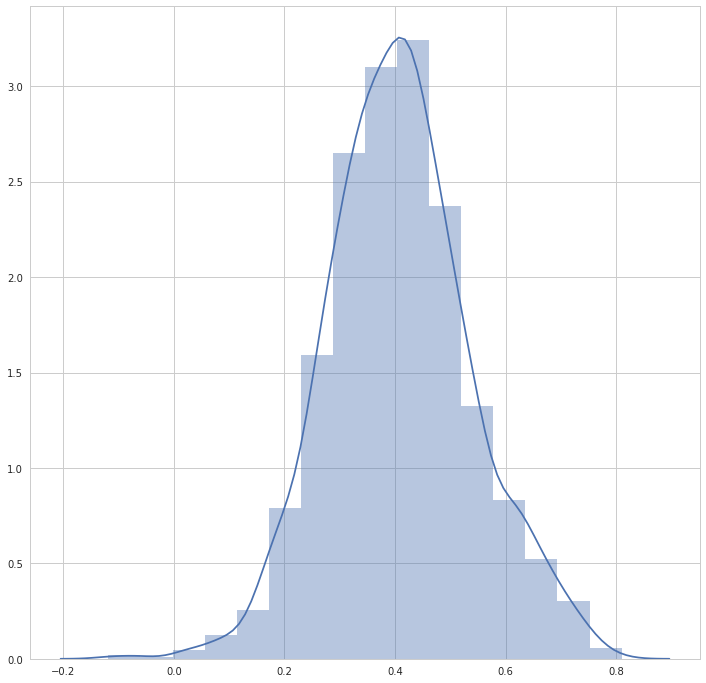

In [5]:
sns.distplot(ndvi_values, bins=16)

In [6]:
nitrogen_ndvi = {}
irrigation_ndvi = {}
for treatment in [100, 50, 25, 0]:
    nitrogen_ndvi[treatment] = []
    irrigation_ndvi[treatment] = []
    for k, v in lettuce_ndvi.items():
        if "N{}".format(treatment) in k:
            nitrogen_ndvi[treatment].append(v)
        if "IR{}".format(treatment) in k:
            irrigation_ndvi[treatment].append(v)

In [7]:
nitrogen_avg = {k:np.average(values) for k, values in nitrogen_ndvi.items()}
nitrogen_stddev = {k:np.std(values) for k, values in nitrogen_ndvi.items()}

print(nitrogen_avg)
print(nitrogen_stddev)

{100: 0.43814675099775457, 50: 0.37512834378158894, 25: 0.38102432847612788, 0: 0.43621192675013193}
{100: 0.13449306095885716, 50: 0.10482269420797329, 25: 0.10808977142065362, 0: 0.14837302908341654}


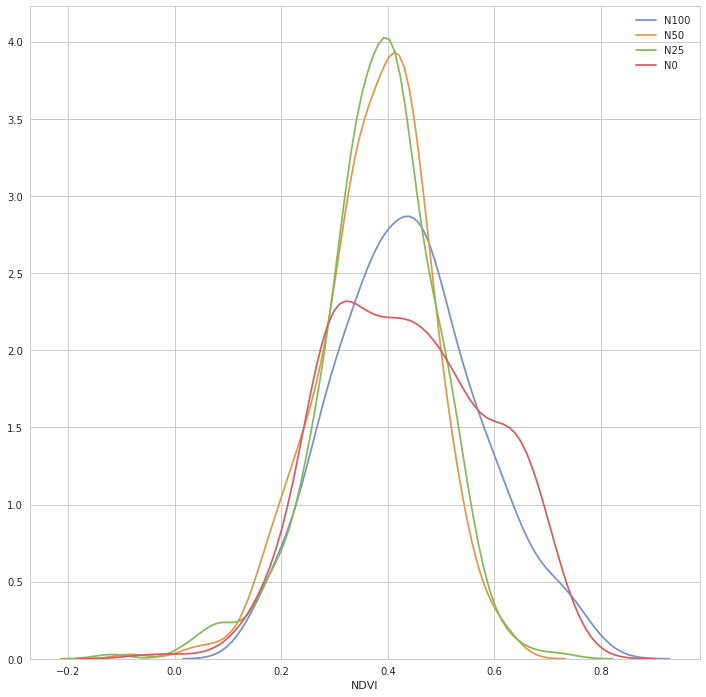

In [8]:
sns.distplot(nitrogen_ndvi[100], bins=16, hist=False, color="#7293CB", label="N100")
sns.distplot(nitrogen_ndvi[50],  bins=16, hist=False, color="#E1974C", label="N50")
sns.distplot(nitrogen_ndvi[25],  bins=16, hist=False, color="#84BA5B", label="N25")
sns.distplot(nitrogen_ndvi[0],   bins=16, hist=False, color="#D35E60", label="N0", axlabel="NDVI")

In [9]:
irrigation_avg = {k:np.average(values) for k, values in irrigation_ndvi.items()}
irrigation_stddev = {k:np.std(values) for k, values in irrigation_ndvi.items()}

print(irrigation_avg)
print(irrigation_stddev)

{100: 0.44025537780282864, 50: 0.41117146448857256, 25: 0.41526737051652823, 0: 0.36431603081187725}
{100: 0.13188544173795114, 50: 0.1206473457261321, 25: 0.12375591156242041, 0: 0.12760895270670933}


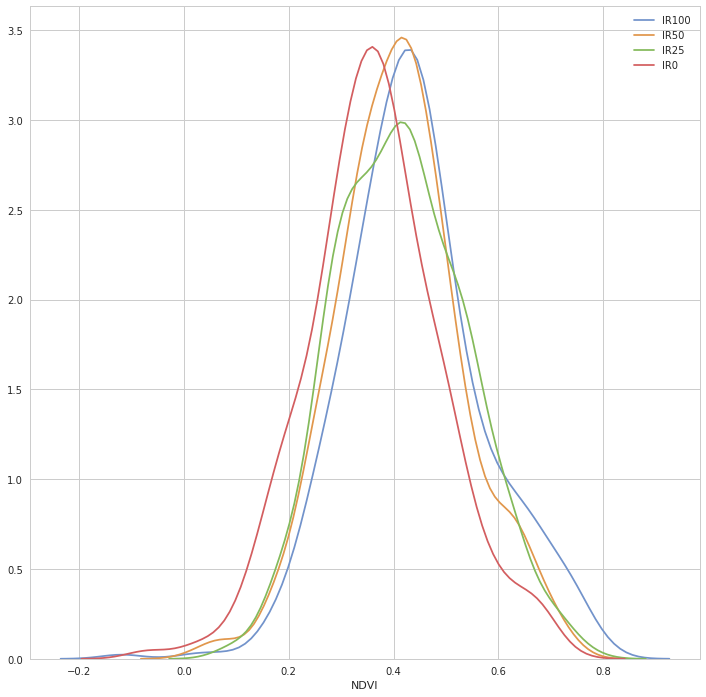

In [10]:
sns.distplot(irrigation_ndvi[100], bins=16, hist=False, color="#7293CB", label="IR100")
sns.distplot(irrigation_ndvi[50],  bins=16, hist=False, color="#E1974C", label="IR50")
sns.distplot(irrigation_ndvi[25],  bins=16, hist=False, color="#84BA5B", label="IR25")
sns.distplot(irrigation_ndvi[0],   bins=16, hist=False, color="#D35E60", label="IR0", axlabel="NDVI")

### Analyze ground data

In [11]:
df = pd.read_csv(csv_file)
df.head()

,Nitrogen,Irrigation,Replication,Plant Number,Chlorophyll,NDVI,WP,Average Height,Average Leaf Count
0,0,0,1,104,48.9,0.805878,-4.80,6,7
1,0,0,1,113,44.4,0.815393,NaN,6,7
2,0,0,2,104,48.8,0.839747,-4.24,4,6
3,0,0,2,113,53.5,0.819832,NaN,4,6
4,0,0,3,104,51.9,0.812323,-4.82,7,6


In [12]:
pre_df = {
    "Nitrogen": [],
    "Irrigation": [],
    "Replication": [],
    "Plant Number": [],
    "uav_ndvi": [],
}
for k, v in lettuce_ndvi.items():
    nitrogen = int(re.search("N(.*)IR.*", k).group(1))
    irrigation = int(re.search(".*IR(.*)Rep.*", k).group(1))
    replication = int(re.search(".*Rep(.*)_", k).group(1))
    number = int(re.search(".*_(.*)", k).group(1))
    
    if number == 104 or number == 113:
        pre_df["Nitrogen"].append(nitrogen)
        pre_df["Irrigation"].append(irrigation)
        pre_df["Replication"].append(replication)
        pre_df["Plant Number"].append(number)
        pre_df["uav_ndvi"].append(v)

ndvi_df = pd.DataFrame(data=pre_df)

In [13]:
merged_df = pd.merge(df, ndvi_df, on=["Nitrogen", "Irrigation", "Replication", "Plant Number"])
merged_df.head()

,Nitrogen,Irrigation,Replication,Plant Number,Chlorophyll,NDVI,WP,Average Height,Average Leaf Count,uav_ndvi
0,0,0,1,104,48.9,0.805878,-4.80,6,7,0.223354
1,0,0,1,113,44.4,0.815393,NaN,6,7,0.353047
2,0,0,2,104,48.8,0.839747,-4.24,4,6,0.260417
3,0,0,2,113,53.5,0.819832,NaN,4,6,0.349006
4,0,0,3,104,51.9,0.812323,-4.82,7,6,0.464699


In [14]:
print("UAV NDVI & Chlorophyll:", stats.pearsonr(merged_df["uav_ndvi"], merged_df["Chlorophyll"])[0])
print("UAV NDVI & NDVI:", stats.pearsonr(merged_df["uav_ndvi"], merged_df["NDVI"])[0])
print("UAV NDVI & Height:", stats.pearsonr(merged_df["uav_ndvi"], merged_df["Average Height"])[0])
print("UAV NDVI & Leaf Count:", stats.pearsonr(merged_df["uav_ndvi"], merged_df["Average Leaf Count"])[0])
print("UAV NDVI & WP:", stats.pearsonr(merged_df.dropna()["uav_ndvi"], merged_df.dropna()["WP"])[0])

UAV NDVI & Chlorophyll: 0.141602050807
UAV NDVI & NDVI: 0.0953184131443
UAV NDVI & Height: 0.193465430132
UAV NDVI & Leaf Count: -0.0822546741617
UAV NDVI & WP: 0.36813781771


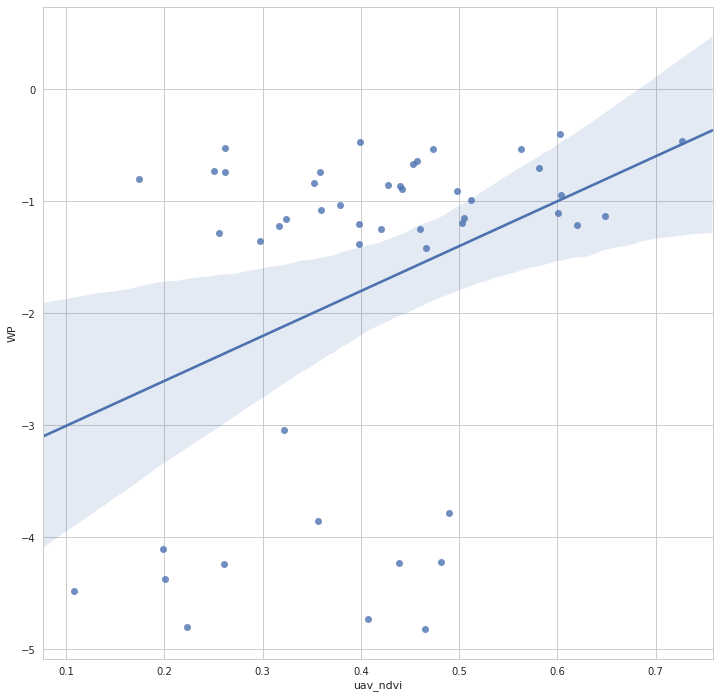

In [15]:
sns.regplot(x=merged_df["uav_ndvi"], y=merged_df["WP"])